#Importing libraries and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import keras.backend as K
import warnings
from sklearn.utils import compute_class_weight
import pywt

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/Covid_mrinal/CovidXRay.rar

Streaming output truncated to the last 5000 lines.
Extracting  Chest X-Ray image dataset/Normal/Normal-6710.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6711.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6712.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6713.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6714.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6715.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6716.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6717.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6718.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6719.png              75%  OK 
Extracting  Chest X-Ray image

#Loading main dataset

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/Chest X-Ray image dataset"):
  class_path = f"/content/Chest X-Ray image dataset/{i}"
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (224, 224)))

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

In [ ]:
# del train_images,train_labels

In [ ]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Y_train = lb.fit_transform(train_labels)
Y_test = lb.transform(test_labels)

#Data Visualization

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:

def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

#Custom Metrics using Tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model =VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
# base_model.summary()
final_model = keras.models.Sequential([base_model, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model.summary()



80150528/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 100356    
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
history = final_model.fit(x=train_images, y=Y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stoping])

Epoch 1/20
424/424 [==============================] - 209s 442ms/step - loss: 3.9972 - accuracy: 0.5403 - precision: 0.8399 - recall: 0.8397 - auc: 0.9081 - specificity: 0.7201 - sensitivity: 0.4210 - mcc: 0.6614 - val_loss: 6.0951 - val_accuracy: 0.6129 - val_precision: 0.8033 - val_recall: 0.8031 - val_auc: 0.8813 - val_specificity: 0.7421 - val_sensitivity: 0.4764 - val_mcc: 0.7121
Epoch 2/20
424/424 [==============================] - 186s 438ms/step - loss: 2.0197 - accuracy: 0.7359 - precision: 0.9192 - recall: 0.9192 - auc: 0.9553 - specificity: 0.8880 - sensitivity: 0.5259 - mcc: 0.8428 - val_loss: 5.4616 - val_accuracy: 0.6987 - val_precision: 0.8409 - val_recall: 0.8409 - val_auc: 0.9031 - val_specificity: 0.7547 - val_sensitivity: 0.5047 - val_mcc: 0.7262
Epoch 3/20
424/424 [==============================] - 185s 437ms/step - loss: 1.6642 - accuracy: 0.8002 - precision: 0.9372 - recall: 0.9372 - auc: 0.9654 - specificity: 0.8966 - sensitivity: 0.5908 - mcc: 0.8611 - val_loss:

In [ ]:
df = data(history)

In [ ]:
df

Accuracy  Validation Accuracy  ...       MCC  Validation MCC
0  0.540255             0.612858  ...  0.661442        0.712125
1  0.735917             0.698701  ...  0.842802        0.726190
2  0.800166             0.809271  ...  0.861078        0.815487
3  0.834884             0.803661  ...  0.906963        0.815166
4  0.862182             0.821819  ...  0.906165        0.762493
5  0.880676             0.818497  ...  0.923309        0.806036
6  0.904153             0.858134  ...  0.940642        0.810320
7  0.915153             0.871346  ...  0.944933        0.849089
8  0.924677             0.885149  ...  0.952116        0.821559

[9 rows x 16 columns]

In [ ]:
df.to_csv("vgg_19_with_30k_with_bwcce.csv")

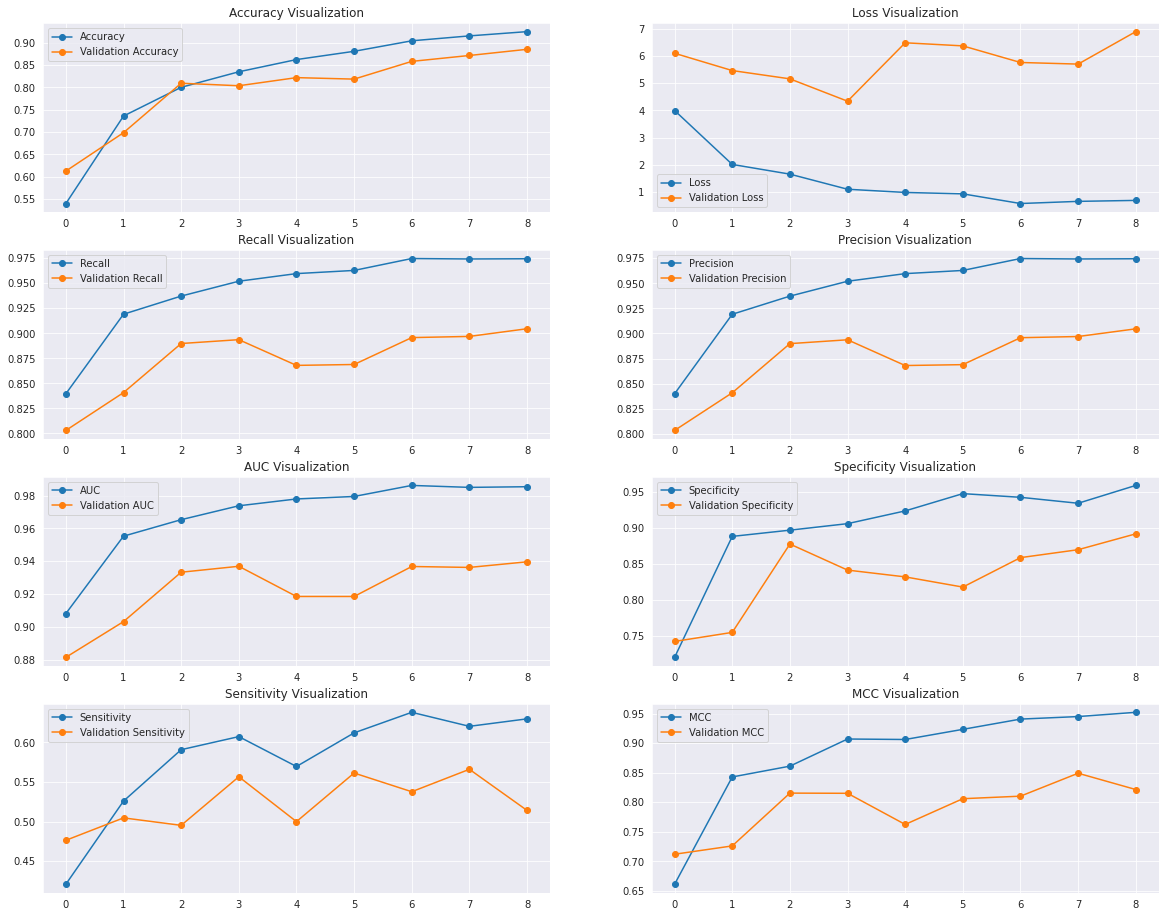

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_best_30k_with_class_weights_with_bwcce.h5")

In [ ]:
predictions = final_model.predict(test_images)
# predictions_index = np.argmax(predictions, axis = -1)
# test_labels_index = np.vectorize(train_dataset.class_indices.get)(test_labels)
print(classification_report(lb.inverse_transform(Y_test), lb.inverse_transform(predictions)))

                 precision    recall  f1-score   support

          COVID       0.96      0.87      0.91       693
   Lung opacity       0.82      0.89      0.85      1181
         Normal       0.92      0.90      0.91      2066
Viral Pneumonia       0.98      0.94      0.96       293

       accuracy                           0.90      4233
      macro avg       0.92      0.90      0.91      4233
   weighted avg       0.90      0.90      0.90      4233

